In [1]:
#import all required libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline


import wordcloud
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# read data and rename columns accordingly

data = pd.read_csv("spam.csv",encoding = 'latin-1')
data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

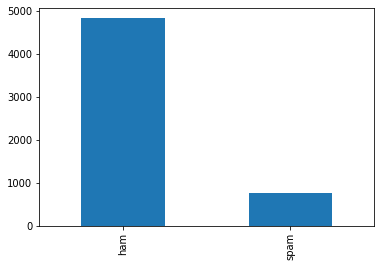

In [4]:
data.label.value_counts().plot.bar()

In [5]:
# Adding spam and length features

data['spam'] = data['label'].map({'ham':0,'spam':1}).astype("int")
data['length'] = data['text'].apply(len)
data.head()

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


(-40, 950)

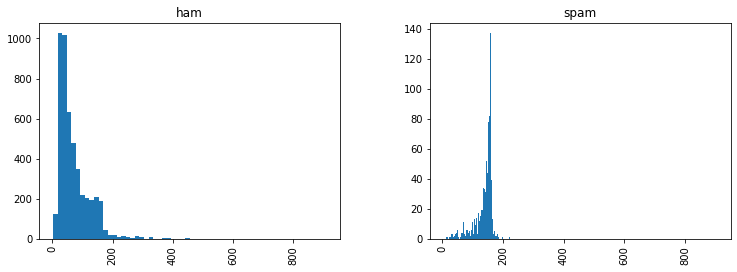

In [6]:
# plot frequency of label as per length of text 

data.hist(column='length',by='label',bins=60,figsize=(12,4))
plt.xlim(-40,950)

In [7]:
# fuctions for showing wordclouds for ham and spam messages

data_ham = data[data['spam']==0].copy()
data_spam = data[data['spam']==1].copy()

def show_wordcloud(data_ham_or_spam,title):
    text = ' '.join(data_ham_or_spam['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                                       colormap='viridis',width=800,height=600).generate(text)
    plt.figure(figsize=(10,7),frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis("Off")
    plt.title(title,fontsize=20)
    plt.show()

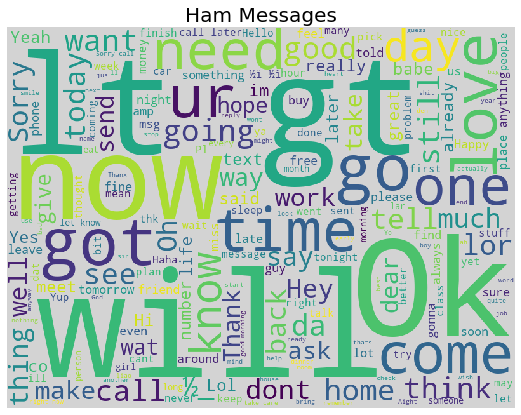

In [8]:
show_wordcloud(data_ham,"Ham Messages")

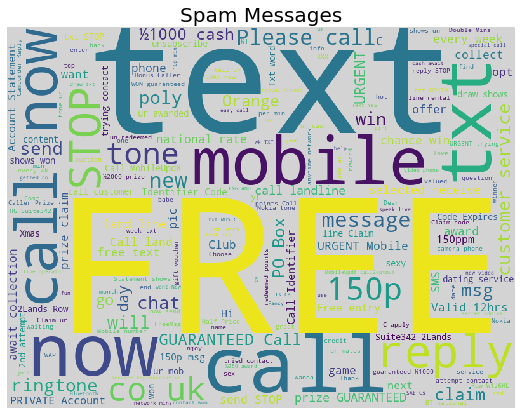

In [9]:
show_wordcloud(data_spam,"Spam Messages")

In [10]:
# function for removing punctuation and stopwrods
# will be used in COuntVectorizer as analyzer

import string

def remove_punctuation_and_stopwords(sms):
    sms_no_punctuation = [ ch for ch in sms if ch not in string.punctuation ]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = [ word.lower() for word in sms_no_punctuation if word.lower() not 
                                      in stopwords.words("english") ]
    return sms_no_punctuation_no_stopwords

In [11]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [12]:
# applying function to separate datasets and converting sms into list of words

data_ham['text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()
data_spam['text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

print(words_data_ham[:5])
print(words_data_spam[:5])

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'u', 'oni'], ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'], ['nah', 'dont', 'think', 'goes', 'usf', 'lives', 'around', 'though'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent']]
[['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', '87121', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', '08452810075over18s'], ['freemsg', 'hey', 'darling', '3', 'weeks', 'word', 'back', 'id', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'ï¿½150', 'rcv'], ['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'ï¿½900', 'prize', 'reward', 'claim', 'call', '09061701461', 'claim', 'code', 'kl341', 'valid', '12', 'hours'], ['mobile', '11', 'months', 'u', 'r', 'entitled', 'update', 'latest', 'colour

In [13]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)
        
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)
        
print(list_ham_words[:10])
print(list_spam_words[:10])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la']
['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts']


In [14]:
# finding count of spam and ham words

from collections import Counter

c_ham = Counter(list_ham_words)
df_ham_top30 = pd.DataFrame(c_ham.most_common(30),columns=['words','count'])
df_ham_top30.head()

,words,count
0,u,972
1,im,449
2,2,305
3,get,303
4,ltgt,276


In [15]:
c_spam = Counter(list_spam_words)
df_spam_top30 = pd.DataFrame(c_spam.most_common(30),columns=['words','count'])
df_spam_top30.head()

,words,count
0,call,347
1,free,216
2,2,173
3,txt,150
4,u,147


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

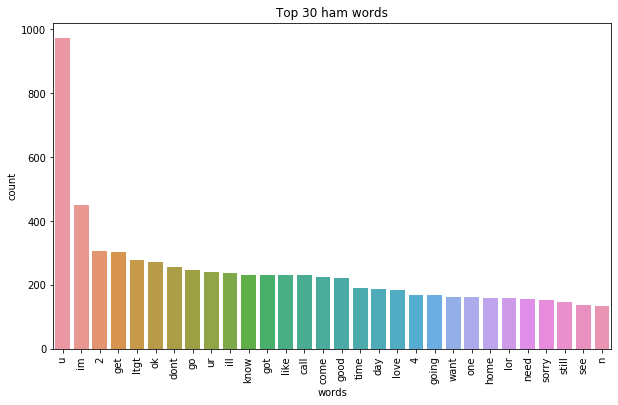

In [16]:
# plot top 30 most common ham words

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='words',y='count',data=df_ham_top30,ax=ax)
plt.title("Top 30 ham words")
plt.xticks(rotation='vertical')

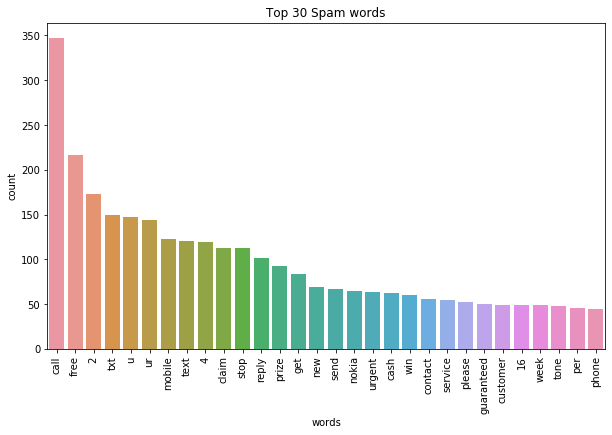

In [17]:
# plot top 30 most common spam words

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='words', y='count', 
            data=df_spam_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

In [18]:
# initialize a vectorizer using function defined above and transform text features

bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])
bow_data = bow_transformer.transform(data['text'])

In [19]:
# initialize tf-idf matrix and transform vectorized data

tfidf_transformer = TfidfTransformer().fit(bow_data)
data_tfidf = tfidf_transformer.transform(bow_data)

In [20]:
np.shape(data_tfidf)

(5572, 9428)

In [21]:
# split the training and testing datasets for modeling

sms_train, sms_test, label_train, label_test = \
    train_test_split(data["text"], data["spam"], test_size=0.3, random_state=5)

In [22]:
# define a pipeline for modeling and run GridSearch for finding best hyoer parameters for SVC model
# fit the training data in SVC model

pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SVC' , SVC(gamma='auto', C=1000)),
                    ])


parameters_SVC = dict(tfidf=[None, TfidfTransformer()],
                      clf_SVC__C=[500, 1000,1500]
                      )
#parameters = {'tfidf__use_idf': (True, False),    }

grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=-1, verbose=1)

grid_SVC.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x7f05cf2ce488>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_rang

In [23]:
# best parameters found by GridSearch and accuracy score

print(grid_SVC.best_params_)
print(grid_SVC.best_score_)

{'clf_SVC__C': 1500, 'tfidf': None}
0.9761538461538461


In [24]:
# Validating model against test dataset

pred_test_grid_SVC = grid_SVC.predict(sms_test)
acc_SVC = accuracy_score(label_test, pred_test_grid_SVC)
print(acc_SVC)
print(grid_SVC.score(sms_test, label_test))

0.9838516746411483
0.9838516746411483
